#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все необходимые библиотеки:

In [31]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as catboost

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [3]:
data=pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


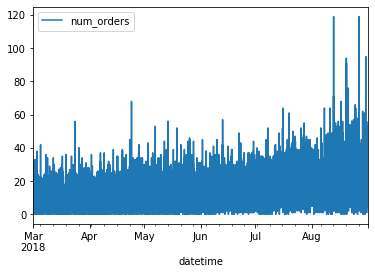

In [5]:
data.plot()

In [6]:
print(data.index.is_monotonic)

True


In [7]:
data=data.resample('1H').sum()

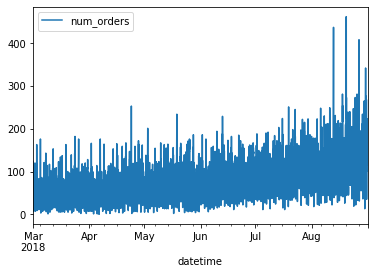

In [8]:
data.plot()

## Анализ

In [9]:
print(data.index.min())
print(data.index.max())
print(data.index.max()-data.index.min())

2018-03-01 00:00:00
2018-08-31 23:00:00
183 days 23:00:00


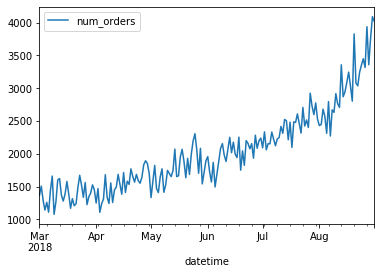

In [10]:
data.resample('1D').sum().plot()

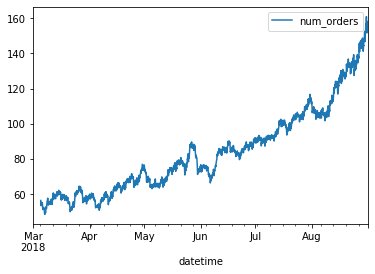

In [11]:
data.rolling(100).mean().plot()

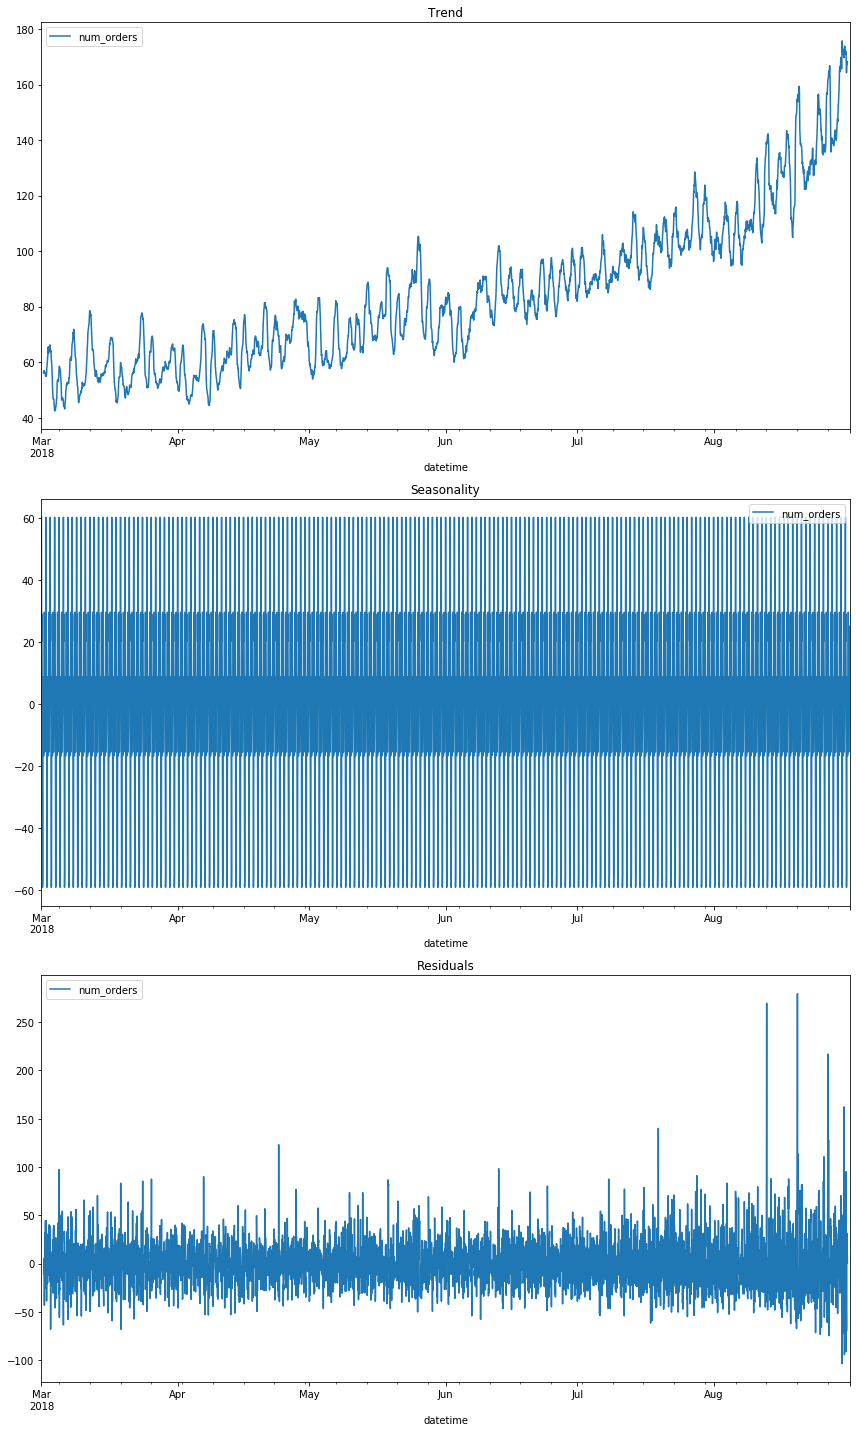

In [12]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

## Обучение

In [13]:
def make_features(data,max_lag,roll):
    data['dayofweek']=data.index.dayofweek
    data['hour']=data.index.hour
    for i in range(1,max_lag+1):
        data['lag_{}'.format(i)]=data['num_orders'].shift(i)
    data['rolling_mean']=data['num_orders'].shift().rolling(roll).mean()
make_features(data,24,100)

In [14]:
data=data.dropna()

In [15]:
display(data)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,157.33
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,156.74
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,156.63


In [16]:
train,test=train_test_split(data,shuffle=False,test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [22]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression.fit(features_train, target_train)
score = abs(pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean())
print(score)

28.41240243714249


In [23]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model = RandomForestRegressor()
parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }
forest = GridSearchCV(model,parametrs, scoring=RMSE_score, cv=my_cv)
forest.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe226ce9d50>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimator...', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_j

In [24]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
cb = catboost.CatBoostRegressor()
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8347707	total: 48.3ms	remaining: 48.2s
100:	learn: 17.9492898	total: 722ms	remaining: 6.43s
200:	learn: 16.0842229	total: 1.4s	remaining: 5.56s
300:	learn: 14.8521484	total: 2.08s	remaining: 4.82s
400:	learn: 13.5729537	total: 2.75s	remaining: 4.12s
500:	learn: 12.5203313	total: 3.43s	remaining: 3.42s
600:	learn: 11.7036985	total: 4.11s	remaining: 2.73s
700:	learn: 10.9473044	total: 4.72s	remaining: 2.01s
800:	learn: 10.2835917	total: 5.4s	remaining: 1.34s
900:	learn: 9.6930777	total: 6.07s	remaining: 667ms
999:	learn: 9.0818401	total: 6.86s	remaining: 0us
0:	learn: 31.8722326	total: 2.84ms	remaining: 2.83s
100:	learn: 20.2493589	total: 1.24s	remaining: 11.1s
200:	learn: 18.5101107	total: 2.61s	remaining: 10.4s
300:	learn: 17.4485035	total: 3.87s	remaining: 8.99s
400:	learn: 16.5733982	total: 5.12s	remaining: 7.65s
500:	learn: 15.8244209	total: 6.47s	remaining: 6.44s
600:	learn: 15.1863347	total: 7.73s	remaining: 5.13s
700:	learn: 14.6399190	total: 8.99s	remaining: 3.84s
8

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe226ce9450>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe226c4ec50>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

## Тестирование

In [25]:
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)
print('RMSE ', RMSE(target_test, regression_model_predictions))

RMSE модели Линейной регрессии: 45.17441695549331


In [26]:
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=13,
                                     min_samples_leaf =3,
                                     min_samples_split = 4,
                                     n_estimators = 25)
forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)
print('RMSE ', RMSE(target_test, forest_model_predictions))

RMSE  42.79762556535308


In [32]:
cb_model = catboost.CatBoostRegressor(learning_rate=0.03,depth=4)
cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)
print('RMSE ', RMSE(target_test, cb_model_predictions))

0:	learn: 38.2170015	total: 2.48ms	remaining: 2.48s
100:	learn: 24.2669641	total: 1.74s	remaining: 15.5s
200:	learn: 22.8477524	total: 3.48s	remaining: 13.8s
300:	learn: 21.6907833	total: 5.23s	remaining: 12.2s
400:	learn: 20.7671769	total: 6.9s	remaining: 10.3s
500:	learn: 19.9969797	total: 8.66s	remaining: 8.63s
600:	learn: 19.3650453	total: 10.7s	remaining: 7.11s
700:	learn: 18.7896640	total: 12.6s	remaining: 5.36s
800:	learn: 18.2751178	total: 14.2s	remaining: 3.54s
900:	learn: 17.7967185	total: 16.1s	remaining: 1.77s
999:	learn: 17.3689475	total: 17.8s	remaining: 0us
RMSE  40.888650070239


Лучший результат показывает CBR(40.88)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48